In [1]:
import librosa
from transformers import Pop2PianoForConditionalGeneration, Pop2PianoProcessor, Pop2PianoTokenizer
import matplotlib.pyplot as plt
import mido
import numpy as np
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
import pretty_midi

/Users/tim/.pyenv/versions/3.11.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = Pop2PianoForConditionalGeneration.from_pretrained("sweetcocoa/pop2piano")
processor = Pop2PianoProcessor.from_pretrained("sweetcocoa/pop2piano")
tokenizer = Pop2PianoTokenizer.from_pretrained("sweetcocoa/pop2piano")

In [212]:
audio, sr = librosa.load("./processed/audio/Mountain - Mississippi Queen.ogg", sr=44100)  # feel free to change the sr to a suitable value.


In [213]:
inputs = processor(audio=audio, sampling_rate=sr, return_tensors="pt")

In [214]:
print(inputs.keys())

dict_keys(['input_features', 'beatsteps', 'extrapolated_beatstep'])


Text(0.5, 1.0, 'Input Spectrogram 0')

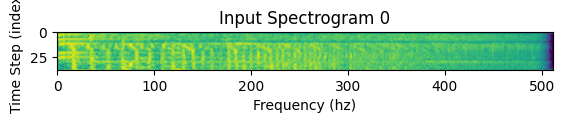

In [215]:
plt.imshow(inputs["input_features"][0])
plt.xlabel("Frequency (hz)")
plt.ylabel("Time Step (index)")
plt.title("Input Spectrogram 0")

In [216]:
# midi = pretty_midi.PrettyMIDI("./mountain.mid")
midi = pretty_midi.PrettyMIDI("./mountain_out_gen.mid")

In [217]:
print(midi.instruments[0].notes)

[Note(start=0.486979, end=0.725260, pitch=55, velocity=77), Note(start=0.725260, end=0.963542, pitch=55, velocity=77), Note(start=0.963542, end=1.190104, pitch=55, velocity=77), Note(start=1.190104, end=1.416667, pitch=40, velocity=77), Note(start=1.190104, end=1.416667, pitch=52, velocity=77), Note(start=1.190104, end=1.416667, pitch=59, velocity=77), Note(start=1.190104, end=1.416667, pitch=62, velocity=77), Note(start=1.416667, end=1.636719, pitch=40, velocity=77), Note(start=1.416667, end=1.636719, pitch=52, velocity=77), Note(start=1.416667, end=1.636719, pitch=59, velocity=77), Note(start=1.416667, end=1.636719, pitch=62, velocity=77), Note(start=1.636719, end=1.858073, pitch=40, velocity=77), Note(start=1.636719, end=1.858073, pitch=52, velocity=77), Note(start=1.636719, end=1.858073, pitch=59, velocity=77), Note(start=1.636719, end=1.858073, pitch=62, velocity=77), Note(start=1.190104, end=1.858073, pitch=68, velocity=77), Note(start=1.858073, end=2.072917, pitch=40, velocity=7

In [218]:
inputs.extrapolated_beatstep

tensor([[  0.0000,   0.2380,   0.4760,   0.7024,   0.9288,   1.1494,   1.3700,
           1.5848,   1.7995,   2.0143,   2.2291,   2.4497,   2.6703,   2.8793,
           3.0883,   3.3088,   3.5294,   3.7442,   3.9590,   4.1738,   4.3886,
           4.6034,   4.8181,   5.0329,   5.2477,   5.4567,   5.6657,   5.8863,
           6.1068,   6.3158,   6.5248,   6.7396,   6.9544,   7.1692,   7.3839,
           7.5929,   7.8019,   8.0109,   8.2199,   8.4346,   8.6494,   8.8642,
           9.0790,   9.2996,   9.5202,   9.7408,   9.9614,  10.1819,  10.4025,
          10.6231,  10.8437,  11.0759,  11.3081,  11.5229,  11.7377,  11.9525,
          12.1673,  12.3762,  12.5852,  12.8000,  13.0148,  13.2238,  13.4327,
          13.6475,  13.8623,  14.0713,  14.2803,  14.5009,  14.7215,  14.9420,
          15.1626,  15.3716,  15.5806,  15.7954,  16.0102,  16.2307,  16.4513,
          16.6661,  16.8809,  17.1015,  17.3221,  17.5485,  17.7749,  17.9955,
          18.2161,  18.4308,  18.6456,  18.8662,  19

In [219]:
num_steps = 2 * 4
num_target_steps = len(inputs.beatsteps[0])
sample_times = []
max_feature_length = 0
for i in range(0, num_target_steps, num_steps):
    start_idx = i
    end_idx = min(i + num_steps, num_target_steps)
    start_time = inputs.extrapolated_beatstep[0][start_idx+1]
    end_time = inputs.extrapolated_beatstep[0][end_idx+1]
    sample_times.append((start_time.item(), end_time.item()))

In [220]:
sample_times

[(0.23800453543663025, 2.0143308639526367),
 (2.0143308639526367, 3.744217872619629),
 (3.744217872619629, 5.456689357757568),
 (5.456689357757568, 7.169160842895508),
 (7.169160842895508, 8.864216804504395),
 (8.864216804504395, 10.623128890991211),
 (10.623128890991211, 12.376235008239746),
 (12.376235008239746, 14.07129192352295),
 (14.07129192352295, 15.795373916625977),
 (15.795373916625977, 17.548480987548828),
 (17.548480987548828, 19.2957820892334),
 (19.2957820892334, 21.03727912902832),
 (21.03727912902832, 22.7497501373291),
 (22.7497501373291, 24.450613021850586),
 (24.450613021850586, 26.180498123168945),
 (26.180498123168945, 27.916189193725586),
 (27.916189193725586, 29.628662109375),
 (29.628662109375, 31.312108993530273),
 (31.312108993530273, 32.99555587768555),
 (32.99555587768555, 34.696414947509766),
 (34.696414947509766, 36.39147186279297),
 (36.39147186279297, 38.09233474731445),
 (38.09233474731445, 39.810611724853516),
 (39.810611724853516, 41.51728057861328),


In [268]:
import copy
def crop_midi(midi, start, end):
    out = copy.deepcopy(midi)
    for note in out.instruments[0].notes.copy():
        if note.start > end or note.start < start:
            out.instruments[0].notes.remove(note)
        note.start = note.start - start
        note.end = note.end - start
    return out

# import copy
# def crop_midi(midi, start, end):
#     out = copy.deepcopy(midi)
#     for note in out.instruments[0].notes.copy():
#         if note.start > end or note.end < start:
#             out.instruments[0].notes.remove(note)
#         note.start = note.start - start
#         note.end = note.end - start
#     return out

In [274]:
print(crop_midi(midi,sample_times[0][0], sample_times[0][1]).instruments[0].notes)#.write("mountain_sample_0.mid")
print(crop_midi(midi,sample_times[1][0], sample_times[1][1]).instruments[0].notes)#.write("mountain_sample_0.mid")

[Note(start=0.248975, end=0.487256, pitch=55, velocity=77), Note(start=0.487256, end=0.725537, pitch=55, velocity=77), Note(start=0.725537, end=0.952100, pitch=55, velocity=77), Note(start=0.952100, end=1.178662, pitch=40, velocity=77), Note(start=0.952100, end=1.178662, pitch=52, velocity=77), Note(start=0.952100, end=1.178662, pitch=59, velocity=77), Note(start=0.952100, end=1.178662, pitch=62, velocity=77), Note(start=1.178662, end=1.398714, pitch=40, velocity=77), Note(start=1.178662, end=1.398714, pitch=52, velocity=77), Note(start=1.178662, end=1.398714, pitch=59, velocity=77), Note(start=1.178662, end=1.398714, pitch=62, velocity=77), Note(start=1.398714, end=1.620068, pitch=40, velocity=77), Note(start=1.398714, end=1.620068, pitch=52, velocity=77), Note(start=1.398714, end=1.620068, pitch=59, velocity=77), Note(start=1.398714, end=1.620068, pitch=62, velocity=77), Note(start=0.952100, end=1.620068, pitch=68, velocity=77), Note(start=1.620068, end=1.834912, pitch=40, velocity=7

In [257]:
batches = [crop_midi(midi, sample_time[0], sample_time[1]).instruments[0].notes for sample_time in sample_times]

In [258]:
len(batches)

89

In [259]:
batches = [batch for batch in batches if len(batch) > 0]
len(batches)

87

In [260]:
# batch = np.array([midi])
# target_token_ids = tokenizer(midi.instruments[0].notes, return_tensors="pt", padding="max_length", max_length=89, truncation=True)
# target_token_ids
# GENERATES TOKENS FROM MIDI. COULD PROBABLY USE THIS TO CALCULATE LOSS
labels = [tokenizer(batch, return_tensors="pt")['token_ids'] for batch in batches]
# labels = np.array([np.append(labels,[1,0])])


In [261]:
labels

[tensor([134, 133,  59, 132,  59, 133,  59, 135, 132,  59, 133,  59, 132,  59,
         133,  44, 132,  44, 133,  56, 132,  56, 133,  63, 132,  63, 133,  66,
         132,  66, 133,  44, 132,  44, 133,  56, 132,  56, 133,  63, 132,  63,
         133,  66, 132,  66, 133,  44,  56,  63,  66,  72, 136, 132,  44,  56,
          63,  66,  72, 133,  44, 132,  44, 133,  56, 132,  56, 133,  63, 132,
          63, 133,  66, 132,  66, 133,  68, 132,  68, 133,  72, 132,  72]),
 tensor([134, 133,  59, 132,  59, 133,  59,  44,  51,  56,  66, 135, 132,  59,
          44,  51,  56, 133,  59, 132,  59,  66, 133,  44, 132,  44, 133,  51,
         132,  51, 133,  56, 132,  56, 133,  59, 132,  59, 133,  66, 132,  66,
         133,  42, 132,  42, 133,  49, 132,  49, 133,  59, 132,  59, 133,  64,
         132,  64, 133,  42,  49,  54,  58,  61,  66, 136, 132,  42,  49,  54,
          58,  61,  66, 133,  42, 132,  42, 133,  49, 132,  49, 133,  54, 132,
          54, 133,  58, 132,  58, 133,  61, 132,  61, 1

In [262]:
labels = [np.append([0], np.append(label, [1, 0])) for label in labels]


In [263]:
longest_length = max([len(label) for label in labels])

In [264]:
padded_labels = [np.pad(label, (0, longest_length - len(label))) for label in labels]

In [265]:
padded_labels

[array([  0, 134, 133,  59, 132,  59, 133,  59, 135, 132,  59, 133,  59,
        132,  59, 133,  44, 132,  44, 133,  56, 132,  56, 133,  63, 132,
         63, 133,  66, 132,  66, 133,  44, 132,  44, 133,  56, 132,  56,
        133,  63, 132,  63, 133,  66, 132,  66, 133,  44,  56,  63,  66,
         72, 136, 132,  44,  56,  63,  66,  72, 133,  44, 132,  44, 133,
         56, 132,  56, 133,  63, 132,  63, 133,  66, 132,  66, 133,  68,
        132,  68, 133,  72, 132,  72,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([  0, 134, 133,  59, 132,  59, 133,  59,  44,  51,  56,  66, 135,
        132,  59,  44,  51,  56, 133,  59, 132,  59,  66, 133,  44, 132,
         44, 133,  51, 132,  51, 133,  56, 132,  56, 133,  59, 1

In [167]:
inputs['input_features']

tensor([[[ 4.5679e+00,  4.3339e+00,  2.3461e+00,  ..., -7.3512e+00,
          -7.3745e+00, -7.3797e+00],
         [ 5.1447e+00,  5.4105e+00,  4.9582e+00,  ..., -8.7370e+00,
          -8.7609e+00, -8.7659e+00],
         [ 7.1270e+00,  7.5228e+00,  8.5967e+00,  ..., -1.3597e+01,
          -1.3816e+01, -1.3816e+01],
         ...,
         [ 2.3277e+00,  1.8064e+00,  2.4003e+00,  ..., -1.2732e+01,
          -1.3816e+01, -1.3816e+01],
         [ 2.4335e+00,  1.3944e+00,  1.8536e+00,  ..., -1.1432e+01,
          -1.1610e+01, -1.1620e+01],
         [ 2.3223e+00,  1.2094e+00, -3.6231e-01,  ..., -5.8425e+00,
          -5.8506e+00, -5.8484e+00]],

        [[ 7.1196e+00,  7.7155e+00,  9.3772e+00,  ..., -6.2546e+00,
          -6.2447e+00, -6.2370e+00],
         [ 7.6712e+00,  8.1921e+00,  9.5093e+00,  ..., -7.6366e+00,
          -7.6309e+00, -7.6232e+00],
         [ 7.2119e+00,  7.6254e+00,  8.6547e+00,  ..., -1.2460e+01,
          -1.3816e+01, -1.3816e+01],
         ...,
         [ 2.4647e+00,  1

In [266]:
tokenizer.num_bars = 2
output = tokenizer.batch_decode(np.array(padded_labels),feature_extractor_output=inputs)

In [267]:
output['pretty_midi_objects'][0].write("mountain_out_good.mid")

In [92]:
model.generation_config.output_logits = True

In [93]:
model.generation_config

GenerationConfig {
  "composer_to_feature_token": {
    "composer1": 2052,
    "composer10": 2061,
    "composer11": 2062,
    "composer12": 2063,
    "composer13": 2064,
    "composer14": 2065,
    "composer15": 2066,
    "composer16": 2067,
    "composer17": 2068,
    "composer18": 2069,
    "composer19": 2070,
    "composer2": 2053,
    "composer20": 2071,
    "composer21": 2072,
    "composer3": 2054,
    "composer4": 2055,
    "composer5": 2056,
    "composer6": 2057,
    "composer7": 2058,
    "composer8": 2059,
    "composer9": 2060
  },
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "max_length": 256,
  "output_logits": true,
  "pad_token_id": 0,
  "return_dict_in_generate": true
}

In [106]:
model_output = model.generate(inputs["input_features"], generation_config=model.generation_config, return_dict_in_generate=True)  


In [109]:
model_output

GenerateEncoderDecoderOutput(sequences=tensor([[  0, 134, 133,  ...,   0,   0,   0],
        [  0, 134, 133,  ...,   0,   0,   0],
        [  0, 134, 133,  ...,   0,   0,   0],
        ...,
        [  0, 134, 133,  ...,   0,   0,   0],
        [  0,   1,   0,  ...,   0,   0,   0],
        [  0,   1,   0,  ...,   0,   0,   0]]), scores=None, logits=(tensor([[ -3.5080,   5.3074, -16.4919,  ..., -16.7558, -16.5689, -16.7493],
        [ -3.6114,   5.2210, -16.8682,  ..., -17.0927, -16.9368, -17.1285],
        [ -3.6364,   5.8048, -15.4844,  ..., -15.7480, -15.5735, -15.7612],
        ...,
        [ -3.7324,   6.2085, -17.3179,  ..., -17.5750, -17.3991, -17.6115],
        [ -1.6280,   9.3496, -13.6123,  ..., -13.8808, -13.6832, -13.8547],
        [ -3.8435,  10.2189, -15.0628,  ..., -15.3787, -15.1447, -15.3224]]), tensor([[-10.1558,   1.8194, -14.7653,  ..., -15.0660, -14.8187, -15.0004],
        [-10.2406,   1.5368, -15.5706,  ..., -15.8555, -15.6065, -15.8007],
        [-10.0275,   2.057

In [211]:
output = tokenizer.batch_decode(
    token_ids=model_output.sequences, feature_extractor_output=inputs
)
output['pretty_midi_objects'][0].write("mountain_out_gen.mid")


In [226]:
# print(model_output.sequences[0])
# print(model_output.sequences[1])
# print(model_output.sequences[2])
print(model_output.sequences[-1])

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])


In [98]:
padded_labels[0]

array([  0, 134, 133,  56, 135, 132,  56, 133,  56, 132,  56, 133,  56,
       132,  56, 133,  56,  63,  72,  44, 136, 132,  56, 133,  56, 132,
        56,  63,  72, 137,  44,   1,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [101]:
padded_labels[1]

array([  0, 135, 133,  63,  72,  44, 136,  56, 132,  56,  63,  72, 133,
        56, 132,  56, 133,  63, 132,  63, 133,  72, 132,  72, 133,  56,
       137, 132,  56,  44, 133,  56, 132,  56, 133,  61, 132,  61, 133,
        59, 132,  59, 133,  56, 132,  56, 133,  73, 132,  73, 133,  44,
       132,  44, 133,  56, 132,  56, 133,  73, 132,  73, 133,  76, 138,
       132,  76,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [15]:
model_output.logits

(tensor([[ -3.5080,   5.3074, -16.4919,  ..., -16.7558, -16.5689, -16.7493],
         [ -3.6114,   5.2210, -16.8682,  ..., -17.0927, -16.9368, -17.1285],
         [ -3.6364,   5.8048, -15.4844,  ..., -15.7480, -15.5735, -15.7612],
         ...,
         [ -3.7324,   6.2085, -17.3179,  ..., -17.5750, -17.3991, -17.6115],
         [ -1.6280,   9.3496, -13.6123,  ..., -13.8808, -13.6832, -13.8547],
         [ -3.8435,  10.2189, -15.0628,  ..., -15.3787, -15.1447, -15.3224]]),
 tensor([[-10.1558,   1.8194, -14.7653,  ..., -15.0660, -14.8187, -15.0004],
         [-10.2406,   1.5368, -15.5706,  ..., -15.8555, -15.6065, -15.8007],
         [-10.0275,   2.0574, -14.5918,  ..., -14.8910, -14.6520, -14.8375],
         ...,
         [-10.6392,   2.3231, -15.2983,  ..., -15.6051, -15.3531, -15.5587],
         [ 18.9714,   1.4675, -13.8516,  ..., -13.9048, -13.8255, -14.0211],
         [ 21.3067,   1.4670, -15.3173,  ..., -15.4150, -15.3594, -15.5076]]),
 tensor([[ -9.7085,  -5.0350, -17.2209,  ...

In [16]:
sequence_output = model_output[0]
sequence_output.size()

torch.Size([89, 100])

In [17]:
labels['token_ids'].size()

torch.Size([89])

In [18]:
model_output.logits

(tensor([[ -3.5080,   5.3074, -16.4919,  ..., -16.7558, -16.5689, -16.7493],
         [ -3.6114,   5.2210, -16.8682,  ..., -17.0927, -16.9368, -17.1285],
         [ -3.6364,   5.8048, -15.4844,  ..., -15.7480, -15.5735, -15.7612],
         ...,
         [ -3.7324,   6.2085, -17.3179,  ..., -17.5750, -17.3991, -17.6115],
         [ -1.6280,   9.3496, -13.6123,  ..., -13.8808, -13.6832, -13.8547],
         [ -3.8435,  10.2189, -15.0628,  ..., -15.3787, -15.1447, -15.3224]]),
 tensor([[-10.1558,   1.8194, -14.7653,  ..., -15.0660, -14.8187, -15.0004],
         [-10.2406,   1.5368, -15.5706,  ..., -15.8555, -15.6065, -15.8007],
         [-10.0275,   2.0574, -14.5918,  ..., -14.8910, -14.6520, -14.8375],
         ...,
         [-10.6392,   2.3231, -15.2983,  ..., -15.6051, -15.3531, -15.5587],
         [ 18.9714,   1.4675, -13.8516,  ..., -13.9048, -13.8255, -14.0211],
         [ 21.3067,   1.4670, -15.3173,  ..., -15.4150, -15.3594, -15.5076]]),
 tensor([[ -9.7085,  -5.0350, -17.2209,  ...

In [19]:
loss = CrossEntropyLoss()
loss(model_output[0].logits, labels['token_ids'].float())


AttributeError: 'Tensor' object has no attribute 'logits'